<a href="https://colab.research.google.com/github/apetulante/Tutorials/blob/master/Transformer_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer Models


Transformers, introduced in the seminal paper "Attention is All You Need" by Vaswani et al., are a major breakthrough in machine learning, especially for natural language processing (NLP). They stand out by processing entire sequences of data in parallel and using self-attention mechanisms to weigh the importance of different parts of the input data. This allows for more efficient training and better handling of long-range dependencies.

Transformers are versatile and used in a variety of tasks, including text translation, content generation, and even in areas beyond NLP, like computer vision.

In this tutorial, we will cover the fundamental breakthroughs of transformers, detailing the main components of the architecture. Then, we'll build and train a simple transformer model.

## Why Transformers?

Natural Language Processing (NLP) tasks are a quintessential example of a sequence which is better treated as a whole rather than as a collection of words.

Consider the sentence: "Time flies like an arrow." In this sentence:

- "Time" is the subject,
- "flies" is the verb,
- "like an arrow" is a metaphorical phrase.

Now consider: "Fruit flies like a banana."

- "Fruit flies" is the subject,
- "like" is the verb,
- "a banana" is the object.

Words here take on very different meanings depending on their context. Flies can be a verb or a noun. Like can be a verb or a preposition. Processing this as a sequence allows models to understand that the arrow is metaphorical in the first sentence, but the banana is a concrete object.

This nuanced understanding is crucial for tasks that require deep comprehension of text, and transformers have built in mechanisms the architecture to treat sequences.

And, it extends beyond just text! While we'll focus on building a transformer to understand text in this tutorial, understand that these same basic principles and architecture can be applied to a variety of other data domains.


## In This Notebook

This tutorial will focus on building a small transformer model using pytorch. We'll focus on understanding *why* transformers work so well, including how data is prepared for a transformer, and how the fundamental **attention mechanism** that makes transformers so useful operates.

## Table of Contents

## Some Setup First

In this tutorial, we'll be making use of some packages to help create us understand, visualize, and create a small transformer model. Before we write any code, we'll import all of the necessary packages here.

We'll start by making sure that our versions of torch and torchtext are compatible and stable. Run the below cell with the `pip install`'s, and when it finishes **go to Runtime -> Restart session** in the toolbar above to be sure that the changes are implemented properly.

In [4]:
!pip install -q torch==2.3.0
!pip install -q torchtext==0.18.0

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

from sklearn.decomposition import PCA

import torch
print("If installs were correct, the version displayed below will be 2.3.0+cu121\n")
print("Version: " + torch.__version__)
import torch.nn as nn
import torchtext
from torchtext.vocab import GloVe
torchtext.disable_torchtext_deprecation_warning() # torchtext is deprecated in future versions and will throw a warning. We've changed torch versions to use it here.

If installs were correct, the version displayed below will be 2.3.0+cu121

Version: 2.3.0+cu121


# 0. Background - Word Processing with NLP's

## 0.1 Word Embeddings

In transformers, the first step in processing text is often converting words into embeddings. These embeddings represent words as vectors of real numbers. This is necessary since computers only process numbers, not words inherently.

Word embeddings are an important concept — unlike simpler representations that treat words as discrete symbols (such as one-hot encoding, where 'dog' is just a unique ID), embeddings represent words as vectors in a continuous space. These vectors not only place similar words closer together in the vector (or 'latent') space but also capture relationships through directionality. For example, not only will "king" and "queen" point to more similar places in the latent space than "apple", but the directional difference between 'king' and 'queen' will also be similar to that between 'man' and 'woman'. In this way, word embeddings reflect *both* semantic similarity and the relationships between words.

Here is a very-simplified visualization of this concept:

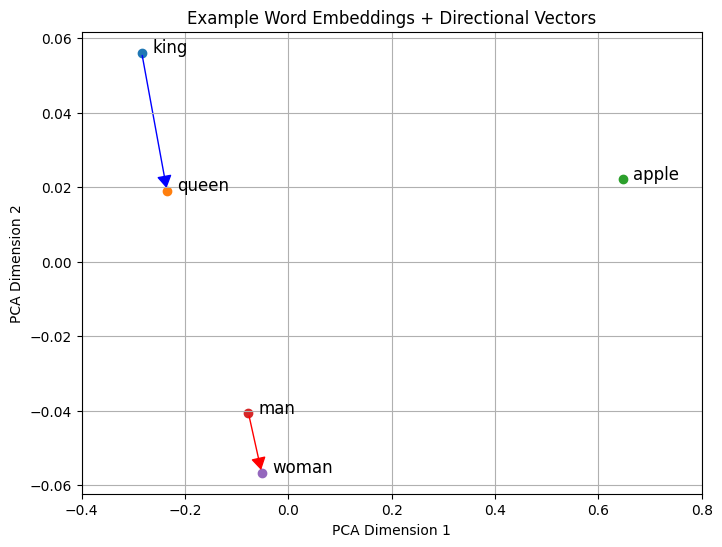

In [29]:
# Example embeddings for a few words, these are made up for now
word_embeddings = {
    'king': [0.8, 0.1, 0.3, 0.5],
    'queen': [0.75, 0.12, 0.35, 0.48],
    'apple': [0.15, 0.76, 0.3, 0.4],
    'man': [0.6, 0.2, 0.35, 0.5],
    'woman': [0.58, 0.22, 0.36, 0.52]
}

# Convert embeddings to 2D using PCA for visualization
pca = PCA(n_components=2)
words = list(word_embeddings.keys())
embeddings = np.array(list(word_embeddings.values()))
reduced_embeddings = pca.fit_transform(embeddings)

# Plot the embeddings in 2D space
plt.figure(figsize=(8, 6))
for i, word in enumerate(words):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label=word)
    plt.text(reduced_embeddings[i, 0] + 0.02, reduced_embeddings[i, 1], word, fontsize=12)

# Use FancyArrowPatch for king-queen and man-woman directional vectors
arrow_king_queen = FancyArrowPatch(posA=reduced_embeddings[0], posB=reduced_embeddings[1],
                                   arrowstyle="-|>,head_width=0.3,head_length=0.5", color='blue', mutation_scale=15, lw=1)
arrow_man_woman = FancyArrowPatch(posA=reduced_embeddings[3], posB=reduced_embeddings[4],
                                  arrowstyle="-|>,head_width=0.3,head_length=0.5", color='red', mutation_scale=15, lw=1)

# Add arrows to the plot
plt.gca().add_patch(arrow_king_queen)
plt.gca().add_patch(arrow_man_woman)

# Final plot adjustments
plt.title('Example Word Embeddings + Directional Vectors')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.grid(True)
plt.xlim([-.4,.8]) #set so apple's label doesn't get cut off, purely visual
plt.show()

So how do we **get** word embeddings? The goal is to transform a word into a vector representation with semantic meaning, so the vectors should contain more info than just their position in a dictionary.

In practice, often pre-trained embedding models are used. Two popular choices are:
* **Word2Vec**: A popular method that uses neural networks to learn word associations from a large corpus of text. It has two main architectures: Continuous Bag of Words (CBOW), where the model predicts a word given its context, and Skip-Gram, where the model predicts the context given a word. Through this process, Word2Vec captures semantic relationships between words.

* **GloVe** (Global Vectors for Word Representation): Another widely used method that generates word embeddings by analyzing word co-occurrences in a corpus. The model trains on the aggregated global word-word co-occurrence statistics from a corpus, capturing both local and global contexts of words.

Because these models were trained with the specific goal of generating word embeddings, they do a great job of embedding semantic meanings of words.

Let's take a look at embeddings the word <font color=green>**"dog"**</font>, with GloVe:

*Note! The below cell may take a while to run! Feel free to skip running this cell and just inspect the cell outputs without re-running.*

In [10]:
# Load pre-trained GloVe embeddings
glove = GloVe(name='6B', dim=100)  # '6B' indicates the corpus used, and 'dim' is the embedding dimension

# Define an embedding layer with pre-trained GloVe weights
embedding_layer = nn.Embedding.from_pretrained(torch.FloatTensor(glove.vectors))

# Example usage
word_idx = glove.stoi['dog']  # Get the index of the word 'dog'
word_embedding = embedding_layer(torch.tensor([word_idx]))  # Retrieve the embedding
print(word_embedding)
print(word_embedding.shape)

.vector_cache/glove.6B.zip: 862MB [11:59, 1.20MB/s]                          
100%|█████████▉| 399999/400000 [00:35<00:00, 11193.78it/s]


tensor([[ 0.3082,  0.3094,  0.5280, -0.9254, -0.7367,  0.6348,  0.4420,  0.1026,
         -0.0914, -0.5661, -0.5327,  0.2013,  0.7704, -0.1398,  0.1373,  1.1128,
          0.8930, -0.1787, -0.0020,  0.5729,  0.5948,  0.5043, -0.2899, -1.3491,
          0.4276,  1.2748, -1.1613, -0.4108,  0.0428,  0.5487,  0.1890,  0.3759,
          0.5803,  0.6697,  0.8116,  0.9386, -0.5100, -0.0701,  0.8282, -0.3535,
          0.2109, -0.2441, -0.1655, -0.7836, -0.4848,  0.3897, -0.8636, -0.0164,
          0.3198, -0.4925, -0.0694,  0.0189, -0.0983,  1.3126, -0.1212, -1.2399,
         -0.0914,  0.3529,  0.6464,  0.0896,  0.7029,  1.1244,  0.3864,  0.5208,
          0.9879,  0.7995, -0.3462,  0.1409,  0.8017,  0.2099, -0.8601, -0.1531,
          0.0745,  0.4082,  0.0192,  0.5159, -0.3443, -0.2453, -0.7798,  0.2743,
          0.2242,  0.2016,  0.0174, -0.0147, -1.0235, -0.3970, -0.0056,  0.3057,
          0.3175,  0.0214,  0.1184, -0.1132,  0.4246,  0.5340, -0.1672, -0.2718,
         -0.6255,  0.1288,  

You'll notice that the word "dog" is now represented as a 100-dimensional vector. In fact, all words that are embedded with GloVe will be 100-dimensional vectors, that tell us vital information about the word's meaning.

You can also train word embeddings from scratch specific to your task using models like the ones mentioned above or as part of a larger model architecture.
This involves adding embedding layers to the front of a model, randomizing the weights, and training it like any other layer in your model.

In this tutorial, we'll be adding one of these embedding layers to our model. We can build an embedding layer simply with PyTorch, and see what might come out of a randomly initialized embedding layer:

In [11]:
vocab_size = 10  # Small vocabulary size for demonstration
embedding_dim = 4  # Small embedding dimension for easy visualization

# Create the embedding layer
embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

# Sample input: indices of words
input_indices = torch.tensor([0, 2, 4, 5, 3])  # Example word indices from the vocabulary, each of these numbers might correspond to a word in the dictionary.

# Sample output: embedding vectors
embedding_vectors = embedding_layer(input_indices)
print(embedding_vectors)

tensor([[-0.4375, -1.0022, -1.2222,  1.6852],
        [-0.7322,  0.0196, -1.2873,  0.0086],
        [ 2.5496,  1.8754, -0.8812, -1.1032],
        [-1.8138,  2.2449,  0.1575,  0.2423],
        [-0.2887,  1.7098,  0.3927,  0.1968]], grad_fn=<EmbeddingBackward0>)


The resulting dimension of word-embedding a text example is an **$n_{words}$** x **$n_{embeds}$** matrix, which represents, for each word in our sentence, an **$n_{embeds}$** - dimensional vector.

# 1. The Building Blocks of Transformers

Transformers rely on a few fundamental concepts. Let's cover each in detail here so we can see how they'll all fit together.

## 1.1 Positional Encodings

We saw above how we can embed words into more useful meanings. But what we did above was turn a sentence into a collection of vocabulary indicies, then each word into a vector embedding.

Transformers can process these embeddings as entire objects (as opposed to, for instance, recurrent neural networks (RNN's), which go one element at a time), which means there's no order of elements in the sequence represented anymore.This is where positional encodings come in. They add unique information to each element in the sequence, giving the model a way to consider the position of each element. Without positional encodings, "I walked my dog" can look the same as "my dog walked I," losing the meaning conveyed by the order of words.

#### 1.1.1 How Positional Encodings are Calculated

Positional encodings are vectors designed to represent the position of elements in a sequence, and they are added to the word embeddings to give the model information about the order of words. Each position in the sequence receives a unique positional encoding. The most commonly used method, introduced in the original Transformer paper, employs sine and cosine functions with different frequencies for each dimension of the encoding:

- For even indices (2i): \begin{equation*} PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right) \end{equation*}
- For odd indices (2i+1): \begin{equation*} PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right) \end{equation*}

where:
- **_pos_** is the position in the sequence (i.e. the number of the word in the sentence or text),
- **_i_** is the dimension in the positional encoding vector, (i runs from 0 -> **$n_{embeds}$**) and
- **$n_{embeds}$** is the dimensionality of the model (i.e., the size of the embedding).

"10000" here is a scaling factor chosen as part of the design of the positional encoding mechanism. This number helps to create a range of wavelengths in the sine and cosine functions, ensuring that each position in the sequence gets a unique and smoothly varying encoding. The choice of 10000 is somewhat arbitrary, but it's based on the intuition that it allows the encoding to generate a wide variety of frequencies.

This approach ensures that each position is given a distinct encoding, while maintaining a level of similarity between encodings for positions that are close to each other. The use of sine and cosine functions allows the model to potentially extrapolate positional encodings for sequence lengths longer than those encountered during training.


#### 1.1.2 Doing the Math for One Example

Let's look into encoding, for instance, the sentence: "I love dogs".

Well say that our word embedding layer embeds each word into a 4-dimensional representation. We'll also say that our model operates on only 3-sentence words. So our maximum sequence length is 3.

From our word embedding layer, we'll get a **3x4** matrix. Then, our positional encoding needs to also be a **3x4** matrix. Let's calculate the first row.

Given:
- The position `pos = 1` (for the first word in the sequence).
- The embedding dimension `n_embeds = 4`.

The positional encoding for each dimension `i` in the first row is calculated as follows:

- For `i = 0` (first dimension, which is even):
  $$ PE_{(1, 2i)} = \sin\left(\frac{1}{10000^{\frac{2i}{d_{\text{model}}}}}\right) = \sin\left(\frac{1}{10000^{0/4}}\right) = \sin(1) $$

- For `i = 1` (second dimension, which is odd):
  $$ PE_{(1, 2i+1)} = \cos\left(\frac{1}{10000^{\frac{2i}{d_{\text{model}}}}}\right) = \cos\left(\frac{1}{10000^{2/4}}\right) = \cos\left(\frac{1}{100}\right) $$

- For `i = 2` (third dimension, which is even):
  $$ PE_{(1, 2i)} = \sin\left(\frac{1}{10000^{\frac{2i}{d_{\text{model}}}}}\right) = \sin\left(\frac{1}{10000^{4/4}}\right) = \sin\left(\frac{1}{10000}\right) $$

- For `i = 3` (fourth dimension, which is odd):
  $$ PE_{(1, 2i+1)} = \cos\left(\frac{1}{10000^{\frac{2i}{d_{\text{model}}}}}\right) = \cos\left(\frac{1}{10000^{6/4}}\right) = \cos\left(\frac{1}{10000^{1.5}}\right) $$

Thus, the first row of the positional encoding matrix for the first position, with a 4-dimensional embedding, is calculated as:
$$ \text{First Row} = [\sin(1), \cos\left(\frac{1}{100}\right), \sin\left(\frac{1}{10000}\right), \cos\left(\frac{1}{10000^{1.5}}\right)] $$

These values, derived from sine and cosine functions, provide a unique encoding that varies smoothly with position, which can then be element-wise added to the word embeddings to incorporate positional information into the model.

If we did this for the rest of the matrix, we should get:

$$
\begin{bmatrix}
\sin(1) & \cos\left(\frac{1}{100}\right) & \sin\left(\frac{1}{10000}\right) & \cos\left(\frac{1}{10000^{1.5}}\right) \\
\sin(2) & \cos\left(\frac{2}{100}\right) & \sin\left(\frac{2}{10000}\right) & \cos\left(\frac{2}{10000^{1.5}}\right) \\
\sin(3) & \cos\left(\frac{3}{100}\right) & \sin\left(\frac{3}{10000}\right) & \cos\left(\frac{3}{10000^{1.5}}\right)
\end{bmatrix}
$$

You'll note here, importantly, that _none of these positional encoding values depended on the word embedding values_. So, a positional encoding matrix can be calculated once, for the expected maximum sequence length, and applied to all examples.


#### 1.1.3 Visualizing Positional Encodings

Let's write some python code to calculate positional encodings, so that we can visualize them.

In [ ]:
def get_positional_encodings(max_seq_length, d_model):
    positional_encodings = np.zeros((max_seq_length, d_model))

    for pos in range(max_seq_length):
        for i in range(d_model):
            denominator = np.power(10000, (2 * (i // 2)) / d_model)
            if i % 2 == 0:
                positional_encodings[pos, i] = np.sin((pos + 1) / denominator)
            else:
                positional_encodings[pos, i] = np.cos((pos + 1) / denominator)

    return positional_encodings

We'll start by visualizing the values of a large matrix of position encodings.

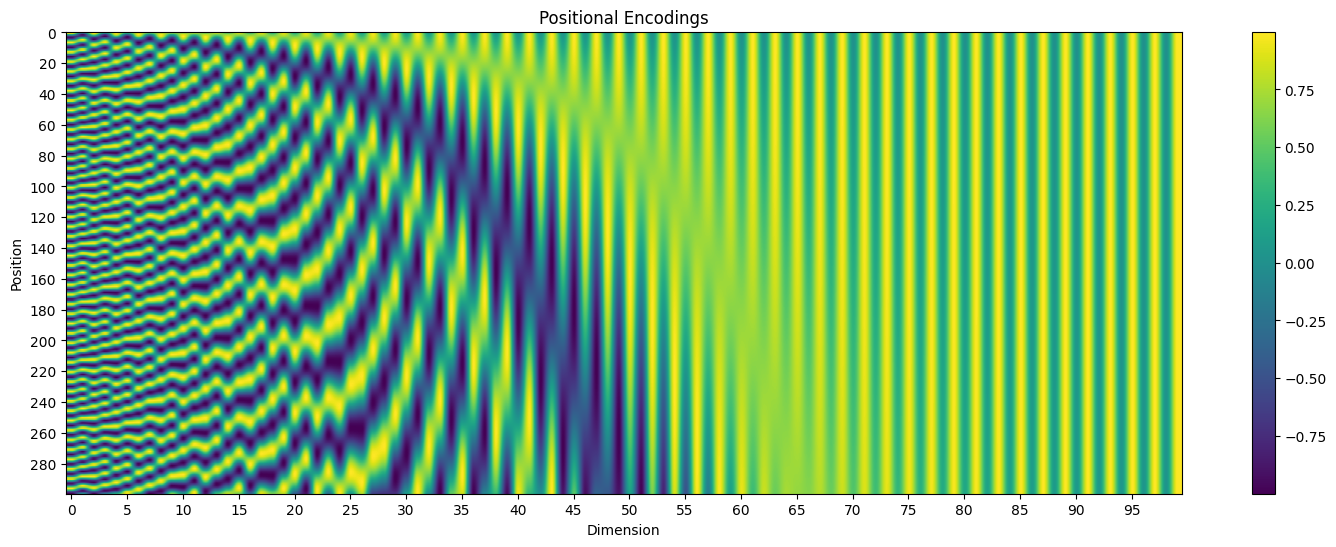

In [ ]:
max_seq_length = 300  # Example maximum sequence length
d_model = 100  # Example embedding dimension

# Generate positional encodings
pos_encodings = get_positional_encodings(max_seq_length, d_model)

# Plot the positional encodings
plt.figure(figsize=(18, 6))
plt.imshow(pos_encodings, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Positional Encodings')
plt.xlabel('Dimension')
plt.ylabel('Position')
plt.xticks(np.arange(0, d_model,5))
plt.yticks(np.arange(0, max_seq_length,20))
plt.show()


This might look confusing.

Early on, in the "Dimension" axis, there's high variability with regards to "Position". These striations increase in size, and become more stripe-like as you move to the right. But remember - the "point" of the positional encoding is NOT in the individual values here! What we're after, rather, is that the **pattern** of any given Position row is unique, and more similar to its neighbors than those far away. We want the Position 100 vector to be more different to the Position 0 vector than the Position 1 vector is to Position 0. This striation pattern ensures that is so.

Indeed, we can plot the **cosine similarity** between these positional encodings to inspect this further. Cosine similarity measures the cosine of the angle between two vectors in a multi-dimensional space. It provides a metric to assess how similar the directions of the two vectors are, regardless of their magnitude.

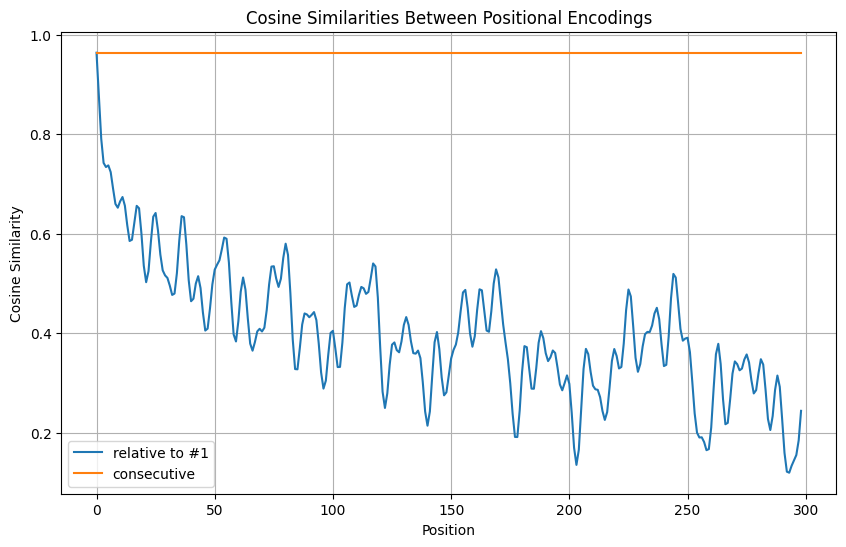

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Initialize a list to store cosine similarities
cosine_similarities = []
cosine_similarities_pairs = []

# Calculate cosine similarity relative to first
for i in range(1,max_seq_length):  # comparisons for positions 0 to max_seq_length with the next position
    sim = cosine_similarity([pos_encodings[0]], [pos_encodings[i]])[0][0]
    cosine_similarities.append(sim)
# Calculate cosine similarity between consecutive positions
for i in range(max_seq_length-1):  # comparisons for positions 0 to max_seq_length with the next position
    sim = cosine_similarity([pos_encodings[i]], [pos_encodings[i + 1]])[0][0]
    cosine_similarities_pairs.append(sim)

plt.figure(figsize=(10, 6))
plt.plot(range(len(cosine_similarities)), cosine_similarities,label='relative to #1')
plt.plot(range(len(cosine_similarities_pairs)), cosine_similarities_pairs, label='consecutive')
plt.title('Cosine Similarities Between Positional Encodings')
plt.xlabel('Position')
plt.ylabel('Cosine Similarity')
plt.grid(True)
plt.legend()

So, we can see that neighboring positions have typically high, and consistently high similarity scores - two positions next to each other have similar position encodings.

On the other hand, the farther away the position is from 1, the lower the similarity score and the more different that positional encoding vector is. This is the behavior we were hoping for!

## 1.2 Self-Attention Mechanisms

Self-attention mechanisms are a groundbreaking feature of transformer models that allow the model to focus on different parts of the input sequence when making predictions.

For example, in the sentence "The cat chased the mouse because it was hungry," to understand what "it" refers to, you need to relate it to "the cat" rather than "the mouse." Self-attention allows the model to make these connections, weighing the importance of each word when considering another word.

#####How It Works
- Query, Key, and Value: For each word in the input, the model generates three vectors—a Query vector, a Key vector, and a Value vector—using learned transformations. You can think of the Query as a representation of a word when it's asking other words, "How relevant are you to me?" The Key is how a word presents itself to be judged by others. The Value is the information other words contribute if they are deemed relevant.

- Attention Scores: The model calculates a score by comparing every Query with every Key. This score determines how much focus (or attention) the model should put on other parts of the input sequence when encoding a particular word. The idea is that words relevant to each other will have higher scores.

- Weighted Sum: The scores are used to weight the Value vectors. These weighted values are then summed up to produce the output for each word, which is a combination of information from the most relevant words in the sequence.

#### 1.2.1 Queries, Keys, and Values

For each word in a sentence, we can assign more meaningful information about its relevance to other words through the **query**, **key**, and **value** vectors.

Semantic embeddings have already transformed each word in our sentence into a *d_model* vector that captures its meaning. And positional embeddings have captured where the word was in the text. Now, each word in the text will additionally have Q,K, and V vectors, which are learned during training, which keep track of how a word relates to other words. The meaning of these vectors draws inspiration from the process of information retrieval, focusing on finding relevant information for a given query.

1. **Query (Q)**: A Query signifies what information is being looked for. In self-attention, it's a vector representation of what relevant information across the entire input sequence is being sought.

2. **Key (K)**: Keys serve as labels or identifiers for the information contained within an input. By comparing a Query to all Keys, the mechanism assesses the relevance of information throughout the input, relative to the Query.

3. **Value (V)**: Values hold the actual information that the Query aims to find. After determining the relevance between a Query and all Keys, the corresponding Values are aggregated in a weighted manner, prioritizing the most relevant information for the output.

These transformations, from the embedding vector into the Q,K,V vectors, are learned transformations, learned through weights of the model and obtained by applying trainable linear transformations (usually fully connected layers) to the input embedding vectors:

- **Mechanism**: Given an input sequence with embedding vectors \(X\), and aiming to generate Queries, Keys, and Values, the model applies three different linear transformations to \(X\):
    - *$Q = X$* $W_{Q}$
    - *$K$ = $X$* $W_{K}$
    - *$V$ = $X$* $W_{V}$
  
  Here, $W_{Q}$, $W_{K}$, and $W_{V}$ are weight matrices that the model learns during training. These matrices start with random values and are updated to minimize the training loss, thus learning to capture and utilize relevant information efficiently.

Let's delve into a simplified numerical example to better grasp the concept:

- Assume each word in your input sequence starts off represented by an embedding vector of size `d_model` (for a very simple example, let's say this is 4). This embedding encapsulates the semantic meaning of each word.
- Learnable weights transform these embeddings into Query (Q), Key (K), and Value (V) vectors for each word. Assuming `d_model` equals 4, then post-transformation, each Q, K, and V vector for a word will also typically span 4 dimensions (though the dimensions can vary if the model architecture dictates so).

We'll go back to our example above of a model that accepts sequence length 3 and has a d_model of 4.

The input sentence is:
$$
input (x) =
\begin{bmatrix}
a & b & c
\end{bmatrix}
$$

We transform this into it's embedding, with one 4-dimensional vector for each of the 3 words:

$$
embed (X) =
\begin{bmatrix}
a_1 & a_2 & a_3 & a_4 \\
b_1 & b_2 & b_3 & b_4 \\
c_1 & c_2 & c_3 & c_4
\end{bmatrix}
$$

Then, each weight vector, $W_{Q}$, $W_{K}$, and $W_{V}$, transforms X into Q,K, and V through matrix multiplication:

$$
Q = X \cdot W_{Q} =
\begin{bmatrix}
a_1 & a_2 & a_3 & a_4 \\
b_1 & b_2 & b_3 & b_4 \\
c_1 & c_2 & c_3 & c_4
\end{bmatrix}
\cdot
\begin{bmatrix}
w_{Q11} & w_{Q12} & w_{Q13} & w_{Q14} \\
w_{Q21} & w_{Q22} & w_{Q23} & w_{Q24} \\
w_{Q31} & w_{Q32} & w_{Q33} & w_{Q34} \\
w_{Q41} & w_{Q42} & w_{Q43} & w_{Q44}
\end{bmatrix}
=
  \begin{bmatrix}
  q_{11} & q_{12} & q_{13} & q_{14} \\
  q_{21} & q_{22} & q_{23} & q_{24} \\
  q_{31} & q_{32} & q_{33} & q_{34}
  \end{bmatrix}
$$

$$
K = X \cdot W_{K} =
\begin{bmatrix}
a_1 & a_2 & a_3 & a_4 \\
b_1 & b_2 & b_3 & b_4 \\
c_1 & c_2 & c_3 & c_4
\end{bmatrix}
\cdot
\begin{bmatrix}
w_{K11} & w_{K12} & w_{K13} & w_{K14} \\
w_{K21} & w_{K22} & w_{K23} & w_{K24} \\
w_{K31} & w_{K32} & w_{K33} & w_{K34} \\
w_{K41} & w_{K42} & w_{K43} & w_{K44}
\end{bmatrix}
=
  \begin{bmatrix}
  k_{11} & k_{12} & k_{13} & k_{14} \\
  k_{21} & k_{22} & k_{23} & k_{24} \\
  k_{31} & k_{32} & k_{33} & k_{34}
  \end{bmatrix}
$$

$$
V = X \cdot W_{V} =
\begin{bmatrix}
a_1 & a_2 & a_3 & a_4 \\
b_1 & b_2 & b_3 & b_4 \\
c_1 & c_2 & c_3 & c_4
\end{bmatrix}
\cdot
\begin{bmatrix}
w_{V11} & w_{V12} & w_{V13} & w_{V14} \\
w_{V21} & w_{V22} & w_{V23} & w_{V24} \\
w_{V31} & w_{V32} & w_{V33} & w_{V34} \\
w_{V41} & w_{V42} & w_{V43} & w_{V44}
\end{bmatrix}
=
  \begin{bmatrix}
  v_{11} & v_{12} & v_{13} & v_{14} \\
  v_{21} & v_{22} & v_{23} & v_{24} \\
  v_{31} & v_{32} & v_{33} & v_{34}
  \end{bmatrix}
$$

Here, each q$_{ij}$, k$_{ij}$, and v$_{ij}$ represents the transformed values for the \(i\)-th word's \(j\)-th dimension in the respective Query, Key, and Value spaces. Each of the w$_{ij}$'s is a learnable parameter of the model.

Typically, of course, the dimensions of the model are much bigger, both in the d$_{model}$ size, and in the maximum sequence length.


#### 1.2.2 Calculating and Using Attention Scores

Queries, keys, and values are useful because they can be interpreted together into an *attention score*, which allows us to re-embed our initial input with new contextual information.

The attention score tells us how much words relate together. It is calculated by comparing each Q vector with all K vectors. It quantifies, for each word in a sentence, how relevant every other word is. A higher score means high relevance, and a lower score means low relevance.

The process of combining Q, K, and V into a meaningful output involves a few steps:

- Calculate Attention Scores: For each Query, calculate a score with every Key. This is often done using the dot product, as it's a simple way to measure how aligned or similar two vectors are.

- Normalization: Use the softmax function to normalize these scores across each row (for each Query). This converts the scores into a probability distribution, ensuring they all add up to 1. Now, each score represents the relative importance of each Key to the Query.

- Weighted Sum: Multiply each normalized score with its corresponding Value vector. This step weights the information (Value vectors) by how relevant it is. Then, sum these weighted Values up to get a single vector for each Query. This resulting vector is a combination of all the original pieces of information, with the most relevant pieces having the most influence.

Continuing with our simple 3x4 example, let's calculate final output of the attention layer by combining Q,K, and V.

Given the Query (Q), Key (K), and Value (V) matrices for our simple example sentence above, we'll walk through the steps to calculate the attention scores and how they're used to create the output.

**Step 1: Calculating Raw Attention Scores.**  The raw attention scores are calculated by performing the dot product of the Q matrix with the transpose of the K matrix:

$$
Attention\ Scores\ (S) = QK^T =
\begin{bmatrix}
q_{11} & q_{12} & q_{13} & q_{14} \\
q_{21} & q_{22} & q_{23} & q_{24} \\
q_{31} & q_{32} & q_{33} & q_{34}
\end{bmatrix}
\cdot
\begin{bmatrix}
k_{11} & k_{21} & k_{31} \\
k_{12} & k_{22} & k_{32} \\
k_{13} & k_{23} & k_{33} \\
k_{14} & k_{24} & k_{34}
\end{bmatrix}
=
\begin{bmatrix}
score_{11} & score_{12} & score_{13} \\
score_{21} & score_{22} & score_{23} \\
score_{31} & score_{32} & score_{33}
\end{bmatrix}
$$

Each element in this matrix represents the raw attention score between two words in the sentence, with each score$_{ij}$ indicating the attention score between the \(i\)-th word and the \(j\)-th word. Each score$_{ij}$ results from the dot product of the \(i\)-th Query vector and the \(j\)-th Key vector, and signifies how much attention the \(i\)-th word should pay to the \(j\)-th word, based on their relevance. A higher score$_{ij}$ suggests that the \(j\)-th word is more relevant or important for understanding the context or meaning of the \(i\)-th word.

- *Diagonal Elements* (score$_{ii}$) represent how each word is self-relevant. The importance of self-interaction varies and is learned by the model based on the training data and task.
  
- *Off-Diagonal Elements* (score$_{ij}$) where \(i $\neq$ j\)) reflect the inter-word relevance as determined by the model's training. Words that are synonyms or typically occur in similar contexts might have higher attention scores relative to each other.


**Step 2: Normalization.** Normalization then transforms the raw attention scores into a distribution that indicates the relative importance of each word in the sequence. This is done typically with the softmax function, which converts a vector of numerical values into a probability distribution. The values produced by softmax are in the range (0, 1) and add up to 1, making them directly interpretable as probabilities.

The softmax function is applied row-wise, so after it is applied, each row in the [seq_length x seq_length] matrix is transformed into a probability distribution.

Given the raw attention scores matrix:

$$
S =
\begin{bmatrix}
score_{11} & score_{12} & score_{13} \\
score_{21} & score_{22} & score_{23} \\
score_{31} & score_{32} & score_{33}
\end{bmatrix}
$$

The softmax function ($
softmax(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}
$) is applied to each row individually:

$$
Attention\ Weights\ (A) =
\begin{bmatrix}
\frac{e^{score_{11}}}{e^{score_{11}} + e^{score_{12}} + e^{score_{13}}} &
\frac{e^{score_{12}}}{e^{score_{11}} + e^{score_{12}} + e^{score_{13}}} &
\frac{e^{score_{13}}}{e^{score_{11}} + e^{score_{12}} + e^{score_{13}}} \\
\frac{e^{score_{21}}}{e^{score_{21}} + e^{score_{22}} + e^{score_{23}}} &
\frac{e^{score_{22}}}{e^{score_{21}} + e^{score_{22}} + e^{score_{23}}} &
\frac{e^{score_{23}}}{e^{score_{21}} + e^{score_{22}} + e^{score_{23}}} \\
\frac{e^{score_{31}}}{e^{score_{31}} + e^{score_{32}} + e^{score_{33}}} &
\frac{e^{score_{32}}}{e^{score_{31}} + e^{score_{32}} + e^{score_{33}}} &
\frac{e^{score_{33}}}{e^{score_{31}} + e^{score_{32}} + e^{score_{33}}}
\end{bmatrix}
=
\begin{bmatrix}
a_{11} & a_{12} & a_{13} \\
a_{21} & a_{22} & a_{23} \\
a_{31} & a_{32} & a_{33} \\
\end{bmatrix}
$$

Each element in this matrix represents the normalized weight of each word's contribution to every other word in the sequence.


**Step 3: Calculating the Weighted Sum.** The final output is calculated by multiplying the normalized attention weights by the V matrix:

$$
Output\ (O) = A \cdot V
$$

$$
O =
\begin{bmatrix}
a_{11} & a_{12} & a_{13} \\
a_{21} & a_{22} & a_{23} \\
a_{31} & a_{32} & a_{33} \\
\end{bmatrix}
\cdot
\begin{bmatrix}
v_{11} & v_{12} & v_{13} & v_{14} \\
v_{21} & v_{22} & v_{23} & v_{24} \\
v_{31} & v_{32} & v_{33} & v_{34}
\end{bmatrix}
=
\begin{bmatrix}
o_{11} & o_{12} & o_{13} & o_{14} \\
o_{21} & o_{22} & o_{23} & o_{24} \\
o_{31} & o_{32} & o_{33} & o_{34}
\end{bmatrix}
$$

This new matrix, **O**, of the same size as the input to the attention layer, encapsulates the aggregated, contextually enriched information for each element in the input sequence. Each row now represents a weighted combination of all input information, with weights reflecting the relevance or attention each word should pay to every other word in the sentence.

- **O** serves as the input to subsequent layers within the model, carrying forward both the intrinsic information of each input element and the contextual relationships learned through the attention mechanism.
- This dynamic incorporation of context from the entire sequence is a key factor behind the effectiveness of models employing self-attention, enabling them to achieve remarkable performance across diverse tasks in natural language processing, computer vision, and other domains.



#### 1.2.3 Attention Mechanism in Code

Now, let's write a simple attention layer and see how we can apply these concepts in code.

In this code, we'll follow the process we just outlined above. We'll
1. Define Q, K, and V matricies by applying the torch.nn.Linear() layer to perform our linear transformations.
2. Calculate attention scores from Q and K
3. Apply the softmax to get attention weights
4. Use V to get the final output.

Then, for a simple 3x4 example embedding, we'll ensure that this layer transforms the input as expected.

In [ ]:
import torch
import torch.nn.functional as F

class SimpleSelfAttention(torch.nn.Module):
    def __init__(self, embed_size):
        super(SimpleSelfAttention, self).__init__()
        self.embed_size = embed_size

        # Linear transformations for Q, K, V
        self.query = torch.nn.Linear(embed_size, embed_size, bias=False)
        self.key = torch.nn.Linear(embed_size, embed_size, bias=False)
        self.value = torch.nn.Linear(embed_size, embed_size, bias=False)

    def forward(self, x):
        # x: [seq_length, embed_size] = [3, 4] for this example

        # Generate Q, K, V matrices
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Calculate attention scores
        attention_scores = torch.matmul(Q, K.transpose(0, 1))

        # Apply softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=-1)

        # Generate the output matrix O by applying attention weights to V
        O = torch.matmul(attention_weights, V)

        return O

# Example usage
embed_size = 4  # Embedding size (d_model)
seq_length = 3  # Sequence length

# Simulate input embeddings: 3 words, each represented by a 4-dimensional vector
x = torch.rand((seq_length, embed_size))  # Random example input

# Initialize the self-attention model and apply it to the input
attention_model = SimpleSelfAttention(embed_size=embed_size)
O = attention_model(x)

print("Input Embeddings (X):", x.numpy())
print("Output Matrix (O):", O.detach().numpy())

Input Embeddings (X): [[0.8267714  0.3452679  0.02221304 0.06506944]
 [0.31626296 0.84939945 0.23200488 0.0658378 ]
 [0.11302221 0.131468   0.19929826 0.5932615 ]]
Output Matrix (O): [[-0.16826338  0.21888673  0.15702875  0.02924475]
 [-0.17030683  0.21099843  0.16601364  0.02585443]
 [-0.17077363  0.21420762  0.1631912   0.02660287]]


#### 1.2.4 Visualizing the Attention Weights

It can be helpful to visualize the attention weight matrix to understand how relations are being made between words. This matrix contains weights that indicate how much focus or "attention" each element in the input sequence should give to every other element.

Visualizations of **A** typically take the form of heatmaps, where the intensity of the colors indicates the strength of the attention weights. This allows us to:

- Trace how the model distributes its attention across the input.
- Identify potential biases or shortcomings in the model's focus.
- Understand which parts of an input sequence are important to a specific word or token, revealing the model's internal "reasoning" and how it processes linguistic structures or dependencies.

We'll come back to this visualization once we have trained a model below, and have an **A** matrix that has some real meaning!

## 1.3 MultiHead Attention

Imagine trying to understand a complex novel. You might focus on understanding the plot. But you may seperately want to better understand a character's development arc. Or maybe the book's thematic elements. Real, complex text has many different, simultaneously occuring aspects. In machine learning models, especially in tasks as nuanced as language processing, there's a wealth of information to be extracted from the data. Multi-head attention allows the model to look at its input from different perspectives (or "heads"), each focusing on different subsets of information, thereby enriching the model's understanding and capabilities.

The essence of multi-head attention is to run several self-attention mechanisms (heads) in parallel, each with its own set of learnable weights, thereby allowing the model to simultaneously attend to information from different representation subspaces at different positions.

#### 1.3.1 How Multi-Head Attention Works

Multi-head attention simply applies the attention mechanism that we just talked about multiple times, using multiple different "heads", then takes an extra step to combine them. Each head $i$ follows the steps of self attention that we just outlined. Namely, for each head, we:

1. Apply separate linear transformations to the Query, Key, and Value matrices.
2. Perform the scaled dot-product attention.
3. Concatenate the attention outputs from each head.
4. Apply a final linear transformation to the concatenated output.

The formula for multi-head attention can be written as:

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O
$$

Where each head is computed as:

$$
\text{head}_i = \text{Attention}(QW^Q_i, KW^K_i, VW^V_i)
$$

as we saw above. Here,
- $W^Q_i, W^K_i, W^V_i$ are the learned weight matrices for the Query, Key, and Value for the \( i \)-th head.
- $W^O$ is the learned weight matrix applied after concatenation.

So, multihead adds this *new* matrix, $W^O$, into the mix, whose job is to learn how to relate all of our different attention heads.
This final transformation with $W^O$ also ensures that the output from the multi-head attention mechanism has the same dimensionality as the input embeddings, so it can be passed on to subsequent layers in the transformer model.

This mechanism allows the model to look at the input from different perspectives simultaneously, improving the model’s ability to capture complex relationships in the data.

#### 1.3.2 Multi-Head Attention Code

Below is an implementation of the multi-head attention mechanism in PyTorch:

In [12]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (self.head_dim * heads == embed_size), "Embedding size must be divisible by heads"

        # Linear layers for query, key, value
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        # Calculate scaled dot-product attention for each head
        attention_scores = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])  # Matrix multiplication

        attention = torch.softmax(attention_scores / (self.embed_size ** (1/2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads * self.head_dim)

        # Pass through final linear layer
        out = self.fc_out(out)

        return out